## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.
For this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#loading csv file in a dataframe
df = pd.read_csv('ab_data.csv')
#displaying first few lines of the dataframe
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
print('The number of rows in the dataset are:', df.count()[0])

The number of rows in the dataset are: 294478


c. The number of unique users in the dataset.

In [4]:
print('The number of unique users in the dataset are:', df.user_id.nunique())

The number of unique users in the dataset are: 290584


d. The proportion of users converted.

In [5]:
conv = df.query('converted == "1"').count()[0] / df.count()[0]
print('The proportion of users converted:', conv)

The proportion of users converted: 0.119659193556


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#rows where control group does not aligns with old page
df_cn = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')]
#rows where treatment group does not aligns with new page
df_to = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]
# Adding the misalignment
count_diff= df_cn.count()[0] + df_to.count()[0]
print('The no. of times both groups do not align with old and new page:', count_diff)

The no. of times both groups do not align with old and new page: 3893


f. Do any of the rows have missing values?

In [7]:
#check any missing value
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#dataframe where control group aligns with old page
df_a = df.query('group == "control" and landing_page == "old_page"')
#dataframe where treatment group aligns with new page
df_b = df.query('group == "treatment" and landing_page == "new_page"')
frames = [df_a, df_b]
#concatenating both dataframes to create a single dataframe
df2 = pd.concat(frames)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
print('The number of unique users in the dataset are:', df2.user_id.nunique())

The number of unique users in the dataset are: 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated() == True]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2.loc[df2.user_id.duplicated(keep = False), :]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
#dropping duplicate userid 
df2.drop([2893], inplace = True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
#probability of user converting regardless of the page they recieve
print("Probability of user converting regardless of the page they recieve:", df2.converted.mean())

Probability of user converting regardless of the page they recieve: 0.119597087245


b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
#probability of user in control group converting
print("Probability of user in control group converting:", df2[df2['group']=='control']['converted'].mean())

Probability of user in control group converting: 0.1203863045


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
#probability of user in treatment group converting
print("Probability of user in treatment group converting:", df2[df2['group']=='treatment']['converted'].mean())

Probability of user in treatment group converting: 0.118808065515


d. What is the probability that an individual received the new page?

In [17]:
#probability of an individual receiving a new page
print("Probability of an individual receiving a new page:", df2.query('landing_page == "new_page"').count()[0] / df2.count()[0])

Probability of an individual receiving a new page: 0.500061944223


e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**We have seen that the probability of recieving a new page 0.5 which suggests that half of the users got the old webpage while the other half got the new one.**

**But the probability of a user converting from control group is 0.120 and from treatment group is 0.118 which does not shows any significicant difference.**

**So we can say based on the above observations that the new or old page does not leads to more conversions, that is the old page is effective as the new one.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$ = $p_{new}$ <=  $p_{old}$**

**$H_{1}$ = $p_{new}$ >  $p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
#Probability of converting if new page is offered
p_new = df2[df2['landing_page']=='new_page']['converted'].mean()
print("Probability of converting if new page is offered:", p_new)

Probability of converting if new page is offered: 0.118808065515


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
#Probability of converting if old page is offered
p_old = df2[df2['landing_page']=='old_page']['converted'].mean()
print("Probability of converting if old page is offered:", p_old)

Probability of converting if old page is offered: 0.1203863045


Assume under the null hypothesis,  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  both have "true" success rates equal to the converted success rate regardless of page - that is  𝑝𝑛𝑒𝑤 and  𝑝𝑜𝑙𝑑  are equal

In [20]:
p_mean = np.mean([p_new, p_old])
print('Convert rate for p_new and p_old under the null hypothesis are:', p_mean)

Convert rate for p_new and p_old under the null hypothesis are: 0.119597185008


c. What is $n_{new}$?

In [21]:
n_new = df2.query('landing_page == "new_page"').count()[0]
print('No. of users recieving the new page:', n_new)

No. of users recieving the new page: 145310


d. What is $n_{old}$?

In [22]:
n_old = df2.query('landing_page == "old_page"').count()[0]
print('No. of users recieving the old page:', n_old)

No. of users recieving the old page: 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
#simulate conversion rates for new page under null hypothesis
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_mean, (1-p_mean)])
p_new = new_page_converted.mean()
p_new

0.11898699332461633

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
#simulate conversion rates for old page under null hypothesis
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_mean, (1-p_mean)])
p_old = old_page_converted.mean()
p_old

0.12020044880708179

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
p_new - p_old

-0.0012134554824654586

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [28]:
p_diffs = []
#simulate 10000 times the difference in conversion rates for old and new page
for i in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_mean, (1-p_mean)])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_mean, (1-p_mean)])
    p_new1 = new_page_converted.mean()
    p_old1 = old_page_converted.mean()
    p_diffs.append(p_new1 - p_old1)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

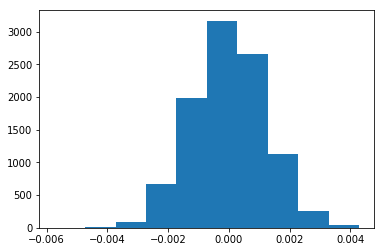

In [29]:
#plotting histogram for our simulated difference
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
p_diff = p_new - p_old
print('Actual Difference: ', p_diff)
#finding proportion of p_diffs greater than the actual difference
diffs = np.array(p_diffs)
null_vals = np.random.normal(0, diffs.std(),diffs.size)
print('Proportion greater than actual difference:', (null_vals > p_diff).mean())

Actual Difference:  -0.00121345548247
Proportion greater than actual difference: 0.8421


k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We just computed the p value which is defined as the probability of obtaining the observed statistic or a "more extreme" value (by extreme we just mean more in favour of the alternate hypothesis mean) if the null hypothesis is true.**

**Since we are observing a high p value so we can say that our null hypothesis is true and the new page is equal to or not better than the old page**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == "1"').count()[0]
convert_new = df2.query('landing_page == "new_page" and converted == "1"').count()[0]

print('The no. of people who got the old page and converted:', convert_old)
print('The no. of people who got the new page and converted:', convert_new)
print('The no. of people who got the old page:', n_old)
print('The no. of people who got the new page:', n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The no. of people who got the old page and converted: 17489
The no. of people who got the new page and converted: 17264
The no. of people who got the old page: 145274
The no. of people who got the new page: 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
#using z test
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
print('z_score:',z_score)
print('p_value:',p_value)

z_score: 1.31092419842
p_value: 0.189883374482


In [33]:
from scipy.stats import norm
# Tells us how significant our z-score is
sig = norm.cdf(z_score)
# Tells us what our critical value at 95% confidence is
conf = norm.ppf(1-(0.05/2))
sig, conf

(0.90505831275902449, 1.959963984540054)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Since the z-score of 1.31 does not exceeds the critical value of 1.959963984540054, we accept the null hypothesis that the difference between the two proportions is no different from zero.**

**Our findings from the previous parts j & k agree with the findings of the z-test**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We will be using logistic regression as this regression approach  is used to predict only two possible outcomes.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [43]:
#creating a copy of df2
df3 = df2
#adding intercept
df3['intercept'] = 1
#creating dummy variables for group
df3[['control', 'treatment']] = pd.get_dummies(df3['group'])
#renaming treatment column to ab page
df3.rename(columns={'treatment': 'ab_page'}, inplace=True)
#dropping control column
df3.drop('control', axis = 1, inplace = True)
#looking at the first few lines of our dataframe
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [44]:
lm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
result = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [45]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        16:31:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p value for the ab_page is 0.19, it differs because we are considering the intercept as well.**

**Here we get a p value of 0.19, since its more than 0.05 this suggests that there is no statistically significant relationship between the variable and response variable.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Since we have found out that our explanatory variable is not that significant so we must consider other factors as well to predict whether the new page is better or not.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [46]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [47]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [48]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [50]:
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 11 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        16:43:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [51]:
np.exp(-1.518), np.exp(0.746)

(0.2191497484416548, 2.1085489299875868)

The countries to which an individual belong shows that a particular country has a greater conversion rate but not that much to be statistically sufficient.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [52]:
lm1 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
result1 = lm1.fit()
result1.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 11 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        17:04:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

# Conclusions

At the beginning we have seen very low conversion rates for both old and new pages and we have very less evidence to reject the null hypothesis.

We also found out that conversion rates were not dependent on countries.

So i will suggest to keep the old page as the new page did not performed that great.

In [54]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0